# 미래에 볼 영화의 평점 예측하기
## Step1. MovieLens 데이터 살펴보기

In [2]:
%matplotlib inline
import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data Source : https://grouplens.org/dataset/movielens
rating_file_path="data/ml-1m/ratings.dat"
movie_file_path="data/ml-1m/movies.dat"
user_file_path="data/ml-1m/users.dat"

rating_data=pd.io.parsers.read_csv(rating_file_path,
                                  names=['user_id', 'movie_id','rating','time'],
                                  delimiter='::')
movie_data=pd.io.parsers.read_csv(movie_file_path,
                                  names=['movie_id','title','genre'],
                                  delimiter='::')
user_data=pd.io.parsers.read_csv(user_file_path,
                                  names=['user_id', 'gender','age','occupation','zipcode'],
                                  delimiter='::')

rating_data.head()

c:\anaconda3\envs\pybook\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
c:\anaconda3\envs\pybook\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()
c:\anaconda3\envs\pybook\lib\site-packages\ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Step2. 분석 : 탐색적 데이터 분석하기

### -영화의 개수와 연도별 탐색에 대한 출력결과

In [6]:
print("total number of movie in data : ", len(movie_data['movie_id'].unique()))

#연도별 영화개수가 가장 많은 Top10연도를 출력합니다.
movie_data['year']=movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10) # 10개의 연도와 개수만 출력
                                                        

total number of movie in data :  3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

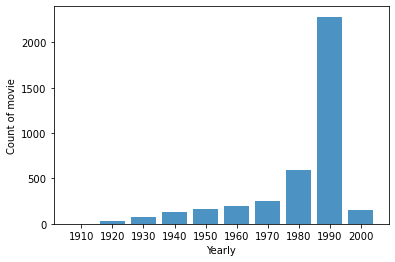

In [7]:
# 미니퀴즈 3-3
# 영화의 연대별 개수를 탐색

movie_data['year_term']=movie_data['title'].apply(lambda x: x[-5:-2]+"0")
movie_year_term=movie_data['year_term'].value_counts().sort_index() # 10개의 연도와 개수만 출력
plt.bar(movie_year_term.index,movie_year_term.values, alpha=0.8)

plt.xlabel('Yearly')
plt.ylabel('Count of movie')
plt.show()

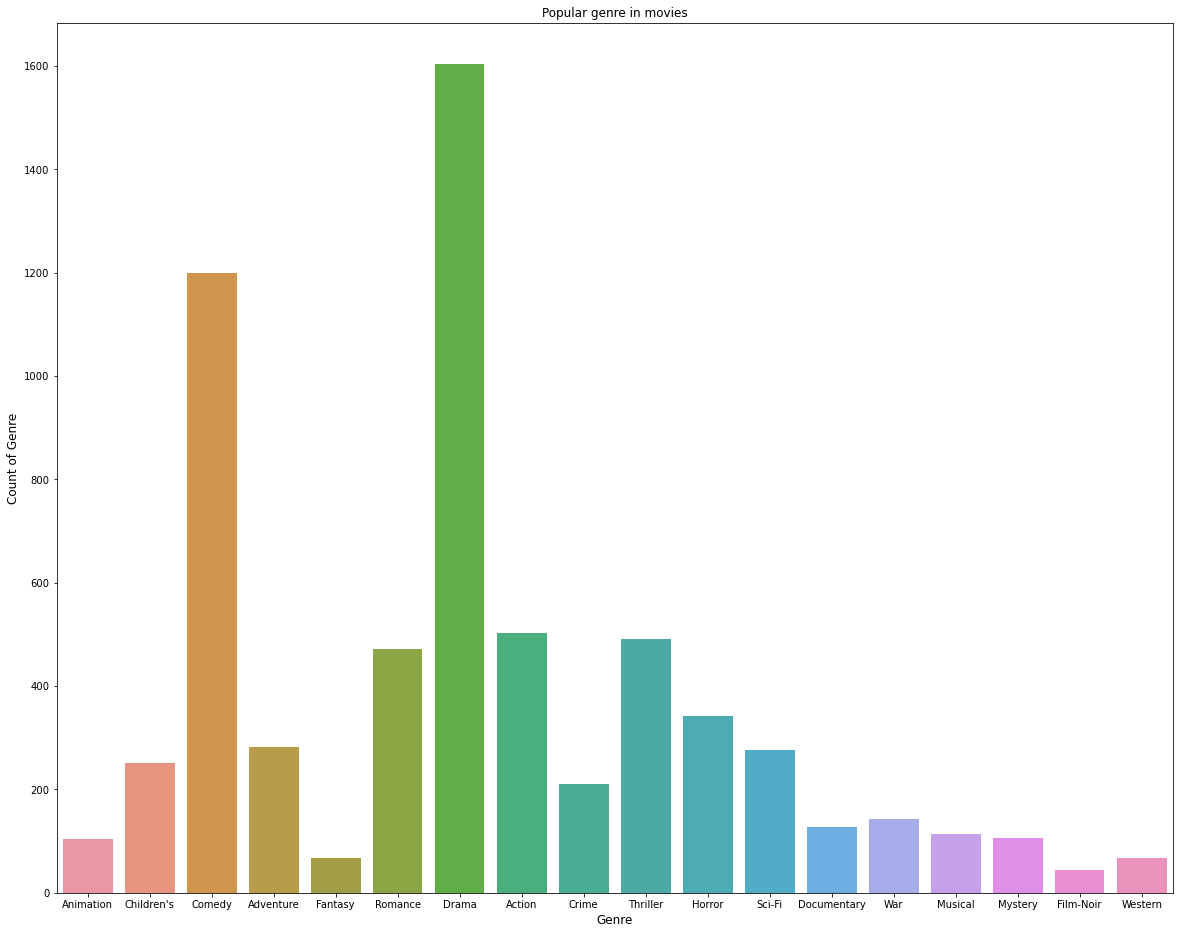

In [8]:
# 장르의 속성 탐색하기
# 가장 많이 등장한 장르의 속성을 추출합니다.
unique_genre_dict={}
for index, row in movie_data.iterrows():
    
    # genre 피처를 '|' 구분자로 분리-> split이용
    genre_combination=row['genre']
    parsed_genre=genre_combination.split("|")
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장
    for genre in parsed_genre:
        if(genre in unique_genre_dict):
            unique_genre_dict[genre]+=1; # dict에 있는 경우 +1
        else:
            unique_genre_dict[genre]=1 # dict에 없는 경우 dict에 추가 
#unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize']=[20,16]
sns.barplot(list(unique_genre_dict.keys()),list(unique_genre_dict.values()))
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre' , fontsize=12)
plt.xlabel('Genre' , fontsize=12)
plt.show()

In [9]:
# 분석할 유저의 정보 탐색하기
print("total number of user in data : ", len(user_data['user_id'].unique()))

total number of user in data :  6040


In [10]:
user_data

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


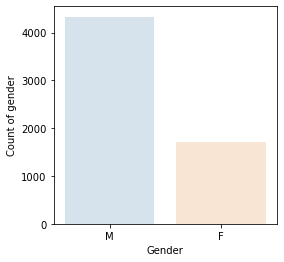

In [11]:
plt.rcParams['figure.figsize']=[4,4] # plt 사이즈 설정
user_gender=user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.2)
plt.xlabel('Gender')
plt.ylabel('Count of gender')
plt.show()

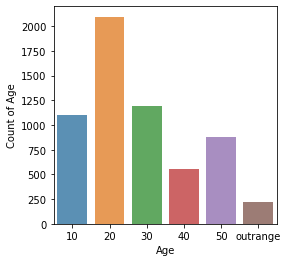

In [12]:
def age_classification(age):
    if age<=1:
        return 'outrange'
    else:
        return str(age)[0]+"0"

user_data['generation']=user_data['age'].apply(lambda x:age_classification(x))
# movie_data['year_term']=movie_data['title'].apply(lambda x: x[-5:-2]+"0")
user_age=user_data['generation'].value_counts().sort_index()
sns.barplot(user_age.index, user_age.values, alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Count of Age')
plt.show()
# user_age=user_data['age'].value_counts()


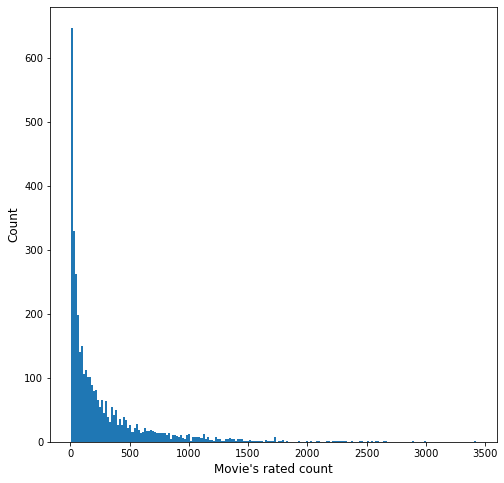

total number of movie in data :  3883
total number of movie rated below 100 :  1687


In [13]:
# movie_id를 기준으로 groupby한뒤 count()함수에 적용한 결과
# X축 평판의 개수 # Y축 평판의 개수의 개수
# 각 영화가 평가받은 횟수를 탐색합니다
movie_rate_count=rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize']=[8,8]
fig=plt.hist(movie_rate_count,bins=200)
plt.ylabel('Count',fontsize=12)
plt.xlabel("Movie's rated count",fontsize=12)
plt.show()

print("total number of movie in data : ", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 : ", len(movie_rate_count[movie_rate_count<100]))


In [14]:
movie_grouped_rating_info=rating_data.groupby('movie_id')['rating'].agg(
  ['count', 'mean'])

<AxesSubplot:>

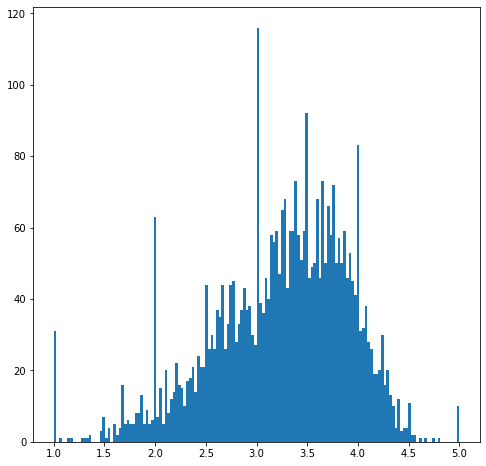

In [15]:
movie_grouped_rating_info['mean'].hist(bins=150, grid=False)

In [16]:
rating_data

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


<AxesSubplot:>

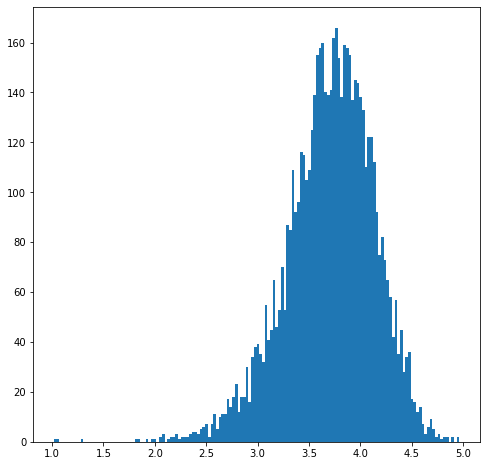

In [17]:
movie_rating_info=rating_data.groupby('user_id')['rating'].agg(
  ['count','mean', 'std']) #user_id 별로 rating을 count,mean,std로 분석
movie_rating_info['mean'].hist(bins=150, grid=False)

In [18]:
# U-I-R 데이터 셋
# 이러한 데이터는 행렬로 나타내기에 매우 용이하며 시각화하기 좋다.
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [19]:
# 행 : user 열 : movie
# USER-MOVIE 형태의 표로 살펴보기
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.

rating_table=rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id","movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

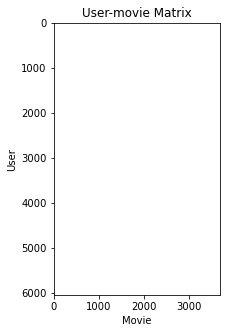

In [20]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

## Step3. 예측: 수학적 기법을 활용해 평점 예측하기

In [21]:
# 비어있는 rating을 채워넣어서 행렬완성
# SVD : mxn행렬을 U, S, V로 나누어서 원래 행렬의 근삿값을 구하는 과정
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [22]:
#SVD 라이브러리를 사용하기 위한 학습데이터를 생성합니다.
reader = Reader(rating_scale=(1,5)) # 평점의 범위가 1~5인 Reader객체를 생성

# rating 데이터를 surprise 라이브러리의 데이터 셋으로 변환
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']],reader)
train_data=data.build_full_trainset()

In [23]:
# SVD 모델을 학습합니다.
train_start=time.time()
model=SVD(n_factors=8,
         lr_all=0.005,
         reg_all=0.02,
         n_epochs=100)
model.fit(train_data)
train_end=time.time()
print("Training time of model : %.2f seconds" %(train_end-train_start))

Training time of model : 213.11 seconds


In [24]:
# 평점 예측 결과 살펴보기
# user_id가 4인 유저의 영화 평가 데이터의 예측 결과 살펴보기
target_user_id=4
target_user_data=rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [40]:
target_user_movie_rating_dict={}
for index, row in target_user_data.iterrows():
    movie_id=row['movie_id']
    target_user_movie_rating_dict[movie_id]=row['rating']
    
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


In [41]:
# 아직 보지 않은 영화들의 평점 예측하기
# model.test() 함수 사용
# test 함수의 입력데이터 user_id, movie_id, rating 형태의 리스트여야 함
# user_id가 4인 유저가 보지 않은 영화 정보를 테스트 데이터로 선정
test_data=[]
for index, row in movie_data.iterrows():
    movie_id=row['movie_id']
    rating=0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating)) # 입력데이터 담기

In [42]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions=model.test(test_data)

In [43]:
# 예측된 점수 중, 타겟 유저의 영화별 점수를 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict={}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id==uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid]=predicted_rating
    return target_user_movie_predict_dict
target_user_movie_predict_dict=get_user_predicted_ratings(predictions=target_user_predictions,
                                                 user_id=target_user_id,
                                                 user_history=target_user_movie_rating_dict)

In [44]:
# 예측된 점수중 top10영화를 선정합니다.
target_user_top10_predicted=sorted(target_user_movie_predict_dict.items(),
                                  key=operator.itemgetter(1),reverse=True)[:10]

In [45]:
target_user_top10_predicted

[(58, 5),
 (106, 5),
 (213, 5),
 (246, 5),
 (309, 5),
 (326, 5),
 (527, 5),
 (570, 5),
 (602, 5),
 (615, 5)]

In [46]:
# Top10 영화의 제목을 매칭하여 출력
movie_dict={}
for index, row in movie_data.iterrows():
    movie_id=row['movie_id']
    movie_title=row['title']
    movie_dict[movie_id]=movie_title

#앞서 계산한 top10 영화목록을 맵핑하여 출력
for predicted in target_user_top10_predicted:
    movie_id=predicted[0]
    predicted_rating=predicted[1]
    print(movie_dict[movie_id],":",predicted_rating)

Postino, Il (The Postman) (1994) : 5
Nobody Loves Me (Keiner liebt mich) (1994) : 5
Burnt By the Sun (Utomlyonnye solntsem) (1994) : 5
Hoop Dreams (1994) : 5
Red Firecracker, Green Firecracker (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Slingshot, The (K�disbellan ) (1993) : 5
Great Day in Harlem, A (1994) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5


## Step4. 평가 : 예측모델 평가하기

In [47]:
# SVD 모델에서 RMSE를 출력
# 학습 데이터셋을 사용하여 SVD 모델을 학습
# 테스트 데이터로 predictions라는 예측값을 생성하여 RMSE를 계산

In [48]:
# SVD라이브러리를 사용하기 위한 학습데이터를 생성
# 학습데이터와 테스트데이터를 8:2로 분할
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(rating_data[['user_id', 'movie_id','rating']],reader)
train_data, test_data=train_test_split(data, test_size=0.2)

In [49]:
# test 데이터로 예측값을 생성하여 RMSE를 출력합니다.
# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=100)
model.fit(train_data)
train_end=time.time()
print("Training time of model : %.2f seconds" % (train_end-train_start))

predictions=model.test(test_data)

Training time of model : 171.84 seconds


In [50]:
# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model")
accuracy.rmse(predictions)

RMSE of test dataset in SVD model
RMSE: 0.8584


0.8583662156277689

In [58]:
# rmse_list_by_factors=[]

# for n in range(1,15):
    # train_start = time.time()
#    model = SVD(n_factors=n,
#               lr_all=0.005,
#               reg_all=0.02,
#               n_epochs=100)
#    model.fit(train_data)
#    # train_end=time.time()
#    # print("Training time of model : %.2f seconds" % (train_end-train_start))
#    predictions=model.test(test_data)
#    rmse_result=accuracy.rmse(predictions)
#    rmse_list_by_factors.append(rmse_result)
# plt.plot(range(1,15),rmse_list_by_factors, alpha=0.8)
# plt.title('RMSE by n_factors of SVD')
# plt.ylabel('RMSE', fontsize=12)
# plt.xlabel('n_factors', fontsize=12)
# plt.show()

In [60]:
# 실제 평점과 비교를 시각화하기
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data=[]
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))
        
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict={}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid]=predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict 에서 예측된 점수 중 타겟 유저의 top10영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions,
                                                            user_id=target_user_id, user_history=target_user_movie_rating_dict)
target_user_movie_predict_dict

{260: 4.639383912206521,
 480: 3.478138996387974,
 1036: 3.8463393751894954,
 1097: 4.554592369520089,
 1196: 4.320822064235483,
 1198: 4.653660709224502,
 1201: 4.566938094763235,
 1210: 4.011909231483326,
 1214: 4.124077234498264,
 1240: 4.018013454408324,
 1387: 4.4131022208826325,
 1954: 4.439052173967081,
 2028: 4.847129935245979,
 2366: 4.0061544641306215,
 2692: 4.28132593602233,
 2947: 4.323379251102795,
 2951: 4.286671862865246,
 3418: 4.171117291381728,
 3468: 5,
 3527: 3.062718701529957,
 3702: 3.8120261483690867}

In [61]:
origin_rating_list=[]
predicted_rating_list=[]
movie_title_list=[]
idx=0

for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx=idx+1
    predicted_rating=round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title=movie_dict[movie_id]
    print("Movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

Movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.64
Movie 2 : Jurassic Park (1993) - 4 / 3.48
Movie 3 : Die Hard (1988) - 4 / 3.85
Movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.55
Movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 4.32
Movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.65
Movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.57
Movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 4.01
Movie 9 : Alien (1979) - 4 / 4.12
Movie 10 : Terminator, The (1984) - 5 / 4.02
Movie 11 : Jaws (1975) - 5 / 4.41
Movie 12 : Rocky (1976) - 5 / 4.44
Movie 13 : Saving Private Ryan (1998) - 5 / 4.85
Movie 14 : King Kong (1933) - 4 / 4.01
Movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.28
Movie 16 : Goldfinger (1964) - 5 / 4.32
Movie 17 : Fistful of Dollars, A (1964) - 4 / 4.29
Movie 18 : Thelma & Louise (1991) - 4 / 4.17
Movie 19 : Hustler, The (1961) - 5 / 5
Movie 20 : Predator (1987) - 1 / 3.06
Movie 21 : Mad Max (1979) - 4 / 3.81


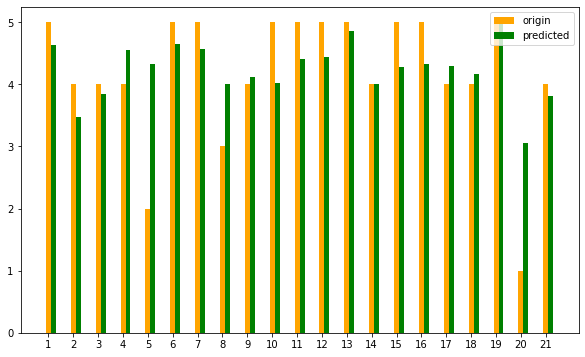

In [62]:
# 실제 평점과의 비교 시각화하기
# 실제 점수와 예측점수를 리스트로 추출합니다.
origin= origin_rating_list
predicted=predicted_rating_list

# 영화의 개수만큼 막대 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize']=(10,6)
index=np.arange(len(movie_title_list))
bar_width=0.2

# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rect1= plt.bar(index, origin, bar_width,color='orange',label='Origin') 
rect2= plt.bar(index+bar_width, predicted, bar_width,color='green',label='Predicted') 
plt.xticks(index, movie_title_list)
plt.legend(['origin','predicted'])
plt.show()